<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install -q kaggle
 from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ssv273","key":"b1885a5edf78a64d77b28215f64fa83a"}'}

In [3]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d carlossalazar65/tropical-genres-dataset
!mkdir Data
!unzip tropical-genres-dataset.zip -d Data

In [17]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков

from tensorflow.keras.optimizers import Adam, RMSprop #Подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

import warnings
warnings.filterwarnings("ignore")

In [7]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
  rmse = np.mean(librosa.feature.rms(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда
  
  
  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля
  
  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [12]:
genres = os.listdir('Data/Audios')
genres

['Cumbia', 'Salsa', 'Bachata', 'Merengue', 'Vallenato']

In [18]:
import time #подключаем модуль time для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'Data/Audios/{g}'):
    #Получаем имя песни
    songname = f'Data/Audios/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр Cumbia готов -> 661c
Жанр Salsa готов -> 664c
Жанр Bachata готов -> 659c
Жанр Merengue готов -> 655c
Жанр Vallenato готов -> 667c


In [20]:
X_train.shape, Y_train.shape

((1500, 37), (1500, 5))

In [21]:
import pickle

In [22]:
with open('X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f)
with open('Y_train.pickle', 'wb') as f:
    pickle.dump(Y_train, f)

In [27]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class[:1000])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [28]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [29]:
#Проверяем, что X_train нормировался
print(X_train[0])

[-0.19440004 -0.02254135 -0.69871085 -0.43679156  0.55959791  0.28266993
 -0.29347755 -1.89927861  1.02926534 -1.15235835  1.00365309 -0.52717217
 -1.49701112  0.26704302 -0.448731   -0.32683994 -0.52126721 -0.23718149
 -1.12200379  0.39318285  0.84458939 -0.83433926 -0.38242429 -1.27880528
 -2.10524687 -0.04902458  0.03910105  1.34750188  0.08400222 -0.77585276
  0.07423673  0.3591292   0.49383772  0.92965758  1.9653544   2.15710755
  1.06342835]


In [30]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [31]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1350, 37)
(1350,)
(150, 37)
(150,)


# Создаём нейронку

Epoch 1/200
68/68 [==============================] - 2s 6ms/step - loss: 1.1305 - accuracy: 0.6096 - val_loss: 0.8336 - val_accuracy: 0.7400
Epoch 2/200
68/68 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.8111 - val_loss: 0.5797 - val_accuracy: 0.8067
Epoch 3/200
68/68 [==============================] - 0s 3ms/step - loss: 0.5007 - accuracy: 0.8511 - val_loss: 0.4539 - val_accuracy: 0.8467
Epoch 4/200
68/68 [==============================] - 0s 3ms/step - loss: 0.3948 - accuracy: 0.8748 - val_loss: 0.3891 - val_accuracy: 0.8400
Epoch 5/200
68/68 [==============================] - 0s 3ms/step - loss: 0.3307 - accuracy: 0.8889 - val_loss: 0.3372 - val_accuracy: 0.8800
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: 0.2870 - accuracy: 0.9037 - val_loss: 0.3058 - val_accuracy: 0.8867
Epoch 7/200
68/68 [==============================] - 0s 3ms/step - loss: 0.2538 - accuracy: 0.9222 - val_loss: 0.2807 - val_accuracy: 0.8867
Epoch 8/200
6

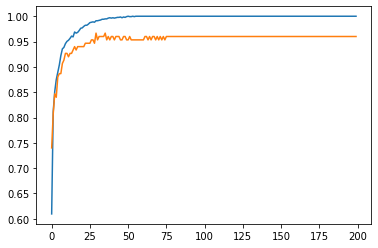

In [32]:
#Указываем, какие индексы данных во входных векторах брать для обучения
#Делаем это для того, чтобы можно было экспериментировать
#И обучать не на всех колонках данных, а на части
indexes = range(0,37)

#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Точность 96% вполне неплохая

# проверим работу

In [33]:
#Выбираем песню для распознавания
songname = '/content/Data/Audios/Cumbia/cumbia0006.mp3'
#Получаем аудио сигнал
y, sr = librosa.load(songname, mono=True, duration=30)
#Параметризуем сигнал
out = get_features(y, sr)
#Добавляем ону размерность, этого требует model.predict
out = np.array(out).reshape(1,37)
#Делаем преобразование
#С помощью scaler, обученного на обучающей выборке
out = scaler.transform(out)
#Делаем predict
y = model.predict(out)
#И распознанный класс
print(np.argmax(y))
print(f"class is {genres[np.argmax(y)]}")

0
class is Cumbia
